# Battle of the Bands: Data gathering<a name="top"></a>

This is a replication of the [fitteR happieR](http://rcharlie.com/2017-02-16-fitteR-happieR/) post which attempted to find the most depressing Radiohead song.

I've redone it here, using tools available in TM351.

I'm also on a bit of a Beatles jag, so I've also done the analysis for The Beatles and The Rolling Stones.

## Contents

* [Getting data from Spotify](#getspotify)
* [Tag album with artist](#tagalbumwithartist)
* [Tag track with artist](#tagtrackwithartist)
* [Get full track data](#fulltrackdata)
* [Lyrics search](#lyricssearch)
* [Matching datasets](#matchingdatasets)
* [Copy the lyrics over](#copylyrics)
* [Sentiment analysis](#sentimentanalysis)
* [Remove live and duplicate tracks](#removedupliates)

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  
import urllib.request
import urllib.parse
import urllib.error
import json
import base64
import configparser
from bs4 import BeautifulSoup
import re
import pymongo
from datetime import datetime
import time
import collections

We'll use MongoDB to store the data, to save keeping it all in memory, and mean we don't have to recapture all the data to to a different analysis.

In [2]:
# Open a connection to the Mongo server
client = pymongo.MongoClient('mongodb://localhost:27017/')

In [3]:
# try:
#     client.drop_database(songs_db)
# except NameError:
#     print("DB doesn't exist yet.")

In [4]:
# Create a database and a collections within it.
songs_db = client.songs
albums = songs_db.albums
tracks = songs_db.tracks
genius_tracks = songs_db.gtracks

API keys and the like are kept in a configuration file, which is read here.

You'll need to create a web API key for Spotify and Genius. 

In [5]:
config = configparser.ConfigParser()
config.read('secrets.ini')
[k for k in config['genius']]

['app_name', 'client_id', 'client_secret', 'redirect_uri', 'token']

In [6]:
## How to write the config file. Fill in the details, and create a different config section for Spotify.
# config['genius'] = {}
# config['genius']['app_name'] = 'xxx'
# config['genius']['client_id'] = 'xxx'
# config['genius']['client_secret'] = 'xxx'
# config['genius']['token'] = 'xxx'
# with open('secrets.ini', 'w') as configfile:
#     config.write(configfile)

In [14]:
stones_id = '22bE4uQ6baNwSHPVcDxLCe'
beatles_id = '3WrFJ7ztbogyGnTHbHJFl2'
radiohead_id = '4Z8W4fKeB5YxbusRsdQVPb'

# Get album and track data from Spotify<a name='getspotify'></a>
We'll download the data on artists, albums, and tracks from Spotify.

* [Top](#top)

In [8]:
def get_spotify_auth_token():
    auth_url = 'https://accounts.spotify.com/api/token'
    auth_data = urllib.parse.urlencode({'grant_type': 'client_credentials'}).encode('utf-8')
    auth_id = base64.standard_b64encode((config['spotify']['client_id'] + \
        ':' + config['spotify']['client_secret']).encode('utf-8')).decode('utf-8)')
    auth_headers = {'Authorization': 'Basic ' + auth_id}
    auth_request = urllib.request.Request(auth_url, data=auth_data, headers=auth_headers)
    with urllib.request.urlopen(auth_request) as f:
        response = json.loads(f.read().decode('utf-8'))
        return response['token_type'], response['access_token']

In [9]:
a_type, a_token = get_spotify_auth_token()

In [10]:
def get_artists(artist_name, auth_type, auth_token):
    headers = {'Authorization': auth_type + ' ' + auth_token}
    query = urllib.parse.urlencode({'q': artist_name, 'type': 'artist'})
    url = 'https://api.spotify.com/v1/search?{}'.format(query)
    request = urllib.request.Request(url, headers=headers, method='GET')

    with urllib.request.urlopen(request) as f:
        response = json.loads(f.read().decode('utf-8'))
        artists = []
        for artist in response['artists']['items']:
            if artist['name'].lower() == artist_name.lower():
                this_artist = {'name': artist['name'], 'id': artist['id']}
                if artist['images']:
                    this_artist['image'] = artist['images'][0]['url']
                artists += [this_artist]
    return artists

In [11]:
artists = get_artists('the rolling stones', a_type, a_token)
stones_id = artists[0]['id']
stones_id, artists

('22bE4uQ6baNwSHPVcDxLCe',
 [{'id': '22bE4uQ6baNwSHPVcDxLCe',
   'image': 'https://i.scdn.co/image/b6b925d5b9f0b5fed8ad52ff887d7351bc7e26c7',
   'name': 'The Rolling Stones'}])

In [12]:
artists = get_artists('the beatles', a_type, a_token)
beatles_id = artists[0]['id']
beatles_id, artists

('3WrFJ7ztbogyGnTHbHJFl2',
 [{'id': '3WrFJ7ztbogyGnTHbHJFl2',
   'image': 'https://i.scdn.co/image/197cff807611777427c93258f0a1ccdf6b013b09',
   'name': 'The Beatles'}])

In [13]:
artists = get_artists('radiohead', a_type, a_token)
radiohead_id = artists[0]['id']
radiohead_id, artists

('4Z8W4fKeB5YxbusRsdQVPb',
 [{'id': '4Z8W4fKeB5YxbusRsdQVPb',
   'image': 'https://i.scdn.co/image/afcd616e1ef2d2786f47b3b4a8a6aeea24a72adc',
   'name': 'Radiohead'},
  {'id': '76j9XexCHSuiclvMCnPg3T', 'name': 'Radiohead'}])

Find all the albums for an artist.

In [20]:
def get_albums(artist_id, auth_type, auth_token):
    headers = {'Authorization': auth_type + ' ' + auth_token}
    url = 'https://api.spotify.com/v1/artists/{a_id}/albums?market=GB&album_type=album'.format(a_id=artist_id)
    request = urllib.request.Request(url, headers=headers, method='GET')
#     request = 'https://api.spotify.com/v1/artists/{id}/albums?market=GB&album_type=album'.format(id=artist_id)
    with urllib.request.urlopen(request) as f:
        response = json.loads(f.read().decode('utf-8'))
        for a in response['items']:
            album_url = a['href']
            album_request = urllib.request.Request(album_url, headers=headers, method='GET')
            with urllib.request.urlopen(album_request) as af:
                album = json.loads(af.read().decode('utf-8'))
                album['_id'] = album['id']
                albums.replace_one({'_id': album['_id']}, album, upsert=True)                

In [30]:
get_albums(beatles_id, a_type, a_token)
albums.find().count()

52

In [31]:
get_albums(stones_id, a_type, a_token)
albums.find().count()

62

In [31]:
get_albums(radiohead_id, a_type, a_token)
albums.find().count()

62

In [32]:
pd.DataFrame(list(albums.find())).head().T

,0,1,2,3,4
_id,5XfJmldgWzrc1AIdbBaVZn,5ju5Ouzan3QwXqQt1Tihbh,2pCqZLeavM2BMovJXsJEIV,2Pqkn9Dq2DFtdfkKAeqgMd,47bcKzmKgmMPHXNVOWpLiu
album_type,album,album,album,album,album
artist_id,NaN,NaN,NaN,NaN,NaN
artist_name,NaN,NaN,NaN,NaN,NaN
artists,[{'href': 'https://api.spotify.com/v1/artists/...,[{'href': 'https://api.spotify.com/v1/artists/...,[{'href': 'https://api.spotify.com/v1/artists/...,[{'href': 'https://api.spotify.com/v1/artists/...,[{'href': 'https://api.spotify.com/v1/artists/...
available_markets,"[AD, AR, AT, AU, BE, BG, BO, BR, CH, CL, CO, C...","[AD, AR, AT, AU, BE, BG, BO, BR, CH, CL, CO, C...","[AD, AR, AT, AU, BE, BG, BO, BR, CH, CL, CO, C...","[AD, AR, AT, AU, BE, BG, BO, BR, CH, CL, CO, C...","[AD, AR, AT, AU, BE, BG, BO, BR, CH, CL, CO, C..."
copyrights,"[{'type': 'C', 'text': '© 2016 Apple Corps Ltd...","[{'type': 'C', 'text': '© 2015 Apple Corps Ltd...","[{'type': 'C', 'text': '© 2015 Apple Corps Ltd...","[{'type': 'C', 'text': '© 2015 Apple Corps Ltd...","[{'type': 'C', 'text': '© 2015 Apple Corps Ltd..."
external_ids,{'upc': '00602557054989'},{'upc': '00602547673503'},{'upc': '00602547670069'},{'upc': '00602547670342'},{'upc': '00602547670328'}
external_urls,{'spotify': 'https://open.spotify.com/album/5X...,{'spotify': 'https://open.spotify.com/album/5j...,{'spotify': 'https://open.spotify.com/album/2p...,{'spotify': 'https://open.spotify.com/album/2P...,{'spotify': 'https://open.spotify.com/album/47...
genres,[],[],[],[],[]


### Tag albums with artists<a name="tagalbumwithartist"></a>
As we have tracks for two artists, let's keep the identification easy and insert the artist name and id into each track document.

* [Top](#top)

In [33]:
for a in albums.find({}, ['artists']):
    albums.update_one({'_id': a['_id']}, 
                      {'$set': {'artist_name': a['artists'][0]['name'],
                                'artist_id': a['artists'][0]['id']}})

In [34]:
pd.DataFrame(list(albums.find({}, ['name', 'artist_name'])))

,_id,artist_name,name
0,5XfJmldgWzrc1AIdbBaVZn,The Beatles,Live At The Hollywood Bowl
1,5ju5Ouzan3QwXqQt1Tihbh,The Beatles,1 (Remastered)
2,2pCqZLeavM2BMovJXsJEIV,The Beatles,Let It Be (Remastered)
3,2Pqkn9Dq2DFtdfkKAeqgMd,The Beatles,Abbey Road (Remastered)
4,47bcKzmKgmMPHXNVOWpLiu,The Beatles,Yellow Submarine (Remastered)
5,03Qh833fEdVT30Pfs93ea6,The Beatles,The Beatles (Remastered)
6,6P9yO0ukhOx3dvmhGKeYoC,The Beatles,Magical Mystery Tour (Remastered)
7,1PULmKbHeOqlkIwcDMNwD4,The Beatles,Sgt. Pepper's Lonely Hearts Club Band (Remaste...
8,0PYyrqs9NXtxPhf0CZkq2L,The Beatles,Revolver (Remastered)
9,3OdI6e43crvyAHhaqpxSyz,The Beatles,Rubber Soul (Remastered)


According to the [Spotify documentation](https://developer.spotify.com/web-api/object-model/#track-object), some objects returned have only a bit of the data, and contain a `href` field for where to find the rest. The track details in the album documents fit that bill, so let's find the full track information.

While doing this, not that Spotify will rate-limit the requests, so we have to include a loop to respect the timeout and retry the requests after the appropriate time.

In [35]:
def get_tracks(album_id, auth_type, auth_token):
    headers = {'Authorization': auth_type + ' ' + auth_token}

    album = albums.find_one({'_id': album_id})
    for t in album['tracks']['items']:
        for _ in range(10):
            try:
                track_request = urllib.request.Request(t['href'], headers=headers, method='GET')
                with urllib.request.urlopen(track_request) as f:                
#                 with urllib.request.urlopen(t['href']) as f:
                    track = json.loads(f.read().decode('utf-8'))
                    track['_id'] = track['id']
                    track['album_id'] = album_id
                    tracks.replace_one({'_id': track['_id']}, track, upsert=True)
                    break
            except urllib.error.HTTPError as e:
                print("Rate limited. Pausing for", e.info()['Retry-After'])
                time.sleep(int(e.info()['Retry-After']) + 0.5)
                continue

In [38]:
a_type, a_token = get_spotify_auth_token()
for album in albums.find():
    get_tracks(album['_id'], a_type, a_token)
tracks.find().count()

Rate limited. Pausing for 1
Rate limited. Pausing for 1
Rate limited. Pausing for 2
Rate limited. Pausing for 2
Rate limited. Pausing for 1
Rate limited. Pausing for 1
Rate limited. Pausing for 1


924

In [39]:
pd.DataFrame(list(tracks.find())).head().T

,0,1,2,3,4
_id,1jgefM2ZP7RnPVShhy1eUM,7FagS2T3y5XwDpYvyHfvmc,1NwDWbpg9dPH12xBd2ibrv,0r5d5LmhLQwJVEw0kTEExp,2vnY8xDhRSW1Cc0xPpUMXc
album,{'artists': [{'href': 'https://api.spotify.com...,{'artists': [{'href': 'https://api.spotify.com...,{'artists': [{'href': 'https://api.spotify.com...,{'artists': [{'href': 'https://api.spotify.com...,{'artists': [{'href': 'https://api.spotify.com...
album_id,3PbRKFafwE7Of8e4dTee72,3PbRKFafwE7Of8e4dTee72,4jbWZmf7kRxCBD6tgVepYh,4jbWZmf7kRxCBD6tgVepYh,4jbWZmf7kRxCBD6tgVepYh
artists,[{'href': 'https://api.spotify.com/v1/artists/...,[{'href': 'https://api.spotify.com/v1/artists/...,[{'href': 'https://api.spotify.com/v1/artists/...,[{'href': 'https://api.spotify.com/v1/artists/...,[{'href': 'https://api.spotify.com/v1/artists/...
available_markets,[GB],[GB],"[AD, AR, AT, AU, BE, BG, BO, BR, CA, CH, CL, C...","[AD, AR, AT, AU, BE, BG, BO, BR, CA, CH, CL, C...","[AD, AR, AT, AU, BE, BG, BO, BR, CA, CH, CL, C..."
disc_number,1,1,1,1,1
duration_ms,191786,303626,255866,254666,246600
explicit,False,False,False,False,False
external_ids,{'isrc': 'GBCBR1500391'},{'isrc': 'GBCBR1500401'},{'isrc': 'GBAAA0000931'},{'isrc': 'GBAAA0000932'},{'isrc': 'GBAAA0000937'}
external_urls,{'spotify': 'https://open.spotify.com/track/1j...,{'spotify': 'https://open.spotify.com/track/7F...,{'spotify': 'https://open.spotify.com/track/1N...,{'spotify': 'https://open.spotify.com/track/0r...,{'spotify': 'https://open.spotify.com/track/2v...


In [40]:
tracks.find_one({}, 'album.id')

{'_id': '1jgefM2ZP7RnPVShhy1eUM'}

### Tag tracks with artist<a name="tagtrackwithartist"></a>
Again, make an easy tag for the artist of each track.

* [Top](#top)

In [42]:
for t in tracks.find({}, ['artists']):
    for a in t['artists']:
        #if a['id'] in [beatles_id, stones_id]:
            tracks.update_one({'_id': t['_id']}, 
                      {'$set': {'artist_name': a['name'],
                                'artist_id': a['id']}})

In [43]:
set(t['artist_name'] for t in tracks.find({}))

{'Billy Preston',
 'Bob Clearmountain',
 'Buddy Guy',
 'Christina Aguilera',
 'Duke Ellington',
 'George Martin',
 'Jack White',
 'Jimi Hendrix',
 'Muddy Waters',
 'Radiohead',
 'Sheryl Crow',
 'Solomon Burke',
 'Spice Girls',
 'The Beatles',
 'The Rolling Stones'}

In [44]:
pd.DataFrame([{'album_id': a['id'], 
              'album_name': a['name'],
              'track_id': t['id'],
              'track_name': t['name'],
              'artist_name': t['artist_name']}
              for a in albums.find()
              for tid in a['tracks']['items']
              for t in tracks.find({'_id': tid['id']})])

,album_id,album_name,artist_name,track_id,track_name
0,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,4edArG2VehvJdwOZfYOxtK,Twist And Shout - Live / Remastered
1,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,150EAeMGWJRubuH8zyx7h8,She's A Woman - Live / Remastered
2,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,1fVeHYkyMxrjbjRAD9uWsZ,Dizzy Miss Lizzy - Live / Remastered
3,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,0GRplBEB2FWCKutwMmS6nY,Ticket To Ride - Live / Remastered
4,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,1eVymk74iroqhsZxm0Vy3g,Can't Buy Me Love - Live / Remastered
5,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,2p5a9gu6NECVSvBtGSU1vm,Things We Said Today - Live / Remastered
6,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,1HyLh5cctOnP186CBi8bhm,Roll Over Beethoven - Live / Remastered
7,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,7fZEWm7TAL2oZDyiYrrgnk,Boys - Live / Remastered
8,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,21nhooOxso7CCoHPE73w4L,A Hard Day's Night - Live / Remastered
9,5XfJmldgWzrc1AIdbBaVZn,Live At The Hollywood Bowl,The Beatles,1alcPfZWUHh01l4Fnoo5Jt,Help! - Live / Remastered


### Get full track data<a name="fulltrackdata"></a>
The full audio analysis requires an API token to get the data. We use the client token to retreive an authorisation token, which will last for about ten minutes.

* [Top](#top)

In [45]:
def get_audio_features(track_ids, auth_type, auth_token):
    url = 'https://api.spotify.com/v1/audio-features?ids={ids}'.format(ids=','.join(track_ids))
    headers = {'Authorization': auth_type + ' ' + auth_token}
    request = urllib.request.Request(url, headers=headers, method='GET')
    
    for _ in range(10):
        try:
            with urllib.request.urlopen(request) as f:
                response = json.loads(f.read().decode('utf-8'))
                for track in response['audio_features']:
                    tracks.update_one({'_id': track['id']}, {'$set': track})
                break
        except urllib.error.HTTPError as e:
            print("Rate limited. Pausing for", e.info()['Retry-After'])
            time.sleep(int(e.info()['Retry-After']) + 0.5)
            continue        

In [46]:
a_type, a_token = get_spotify_auth_token()
for a in albums.find({}, []):
    track_ids = [t['_id'] for t in tracks.find({'album.id': a['_id']}, [])]
    get_audio_features(track_ids, a_type, a_token)

In [18]:
beatles_tracks = pd.DataFrame(list(tracks.find({'artist_id': beatles_id})))
beatles_tracks.T

,0,1,2,3,4,5,6,7,8,9,...,251,252,253,254,255,256,257,258,259,260
_id,2ucFulEWapRAmTn7l6f5Q7,2z1p43SNSbeowzy8WdYHNk,3ckvsHnEffhhS5c0Cs6Gv5,5cXiWs6VoLlDlowJQo0UPk,4edArG2VehvJdwOZfYOxtK,150EAeMGWJRubuH8zyx7h8,1fVeHYkyMxrjbjRAD9uWsZ,0GRplBEB2FWCKutwMmS6nY,1eVymk74iroqhsZxm0Vy3g,2p5a9gu6NECVSvBtGSU1vm,...,3pY5chBSUotRa6RoIfwJjc,5ToEv4nDN51OyAjK65A9YS,3ZFPe2aiLQuEfDxSqQstZp,2BOawXVznHmi2KJzRFstBN,1alxZZpi5dBLcmV3WkYIzN,1k1kJBeaL3FCUG2vOJ1z0g,42uZOBjvKNv4QKnBmjOwb0,5JnPM6eKhHJtkWfS6ymUMF,3HEC6nzAo3U5z7blaCNBcF,3qchAN1uJ1KiF8yxmqb3Ov
acousticness,0.425,0.368,0.614,0.22,7.67e-05,0.00675,0.0131,0.00327,0.00865,0.0836,...,0.000366,0.000236,0.254,0.291,0.232,0.749,0.447,0.162,0.919,0.482
album,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...
album_id,03Qh833fEdVT30Pfs93ea6,6P9yO0ukhOx3dvmhGKeYoC,7BgGBZndAvDlKOcwe5rscZ,3LXItxKnnJcEDc5QdTc00n,5XfJmldgWzrc1AIdbBaVZn,5XfJmldgWzrc1AIdbBaVZn,5XfJmldgWzrc1AIdbBaVZn,5XfJmldgWzrc1AIdbBaVZn,5XfJmldgWzrc1AIdbBaVZn,5XfJmldgWzrc1AIdbBaVZn,...,3LXItxKnnJcEDc5QdTc00n,3LXItxKnnJcEDc5QdTc00n,3LXItxKnnJcEDc5QdTc00n,3LXItxKnnJcEDc5QdTc00n,3LXItxKnnJcEDc5QdTc00n,3LXItxKnnJcEDc5QdTc00n,3LXItxKnnJcEDc5QdTc00n,3LXItxKnnJcEDc5QdTc00n,3LXItxKnnJcEDc5QdTc00n,3LXItxKnnJcEDc5QdTc00n
analysis_url,https://api.spotify.com/v1/audio-analysis/2ucF...,https://api.spotify.com/v1/audio-analysis/2z1p...,https://api.spotify.com/v1/audio-analysis/3ckv...,https://api.spotify.com/v1/audio-analysis/5cXi...,https://api.spotify.com/v1/audio-analysis/4edA...,https://api.spotify.com/v1/audio-analysis/150E...,https://api.spotify.com/v1/audio-analysis/1fVe...,https://api.spotify.com/v1/audio-analysis/0GRp...,https://api.spotify.com/v1/audio-analysis/1eVy...,https://api.spotify.com/v1/audio-analysis/2p5a...,...,https://api.spotify.com/v1/audio-analysis/3pY5...,https://api.spotify.com/v1/audio-analysis/5ToE...,https://api.spotify.com/v1/audio-analysis/3ZFP...,https://api.spotify.com/v1/audio-analysis/2BOa...,https://api.spotify.com/v1/audio-analysis/1alx...,https://api.spotify.com/v1/audio-analysis/1k1k...,https://api.spotify.com/v1/audio-analysis/42uZ...,https://api.spotify.com/v1/audio-analysis/5JnP...,https://api.spotify.com/v1/audio-analysis/3HEC...,https://api.spotify.com/v1/audio-analysis/3qch...
artist_id,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,...,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2,3WrFJ7ztbogyGnTHbHJFl2
artist_name,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,...,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles,The Beatles
artists,[{'external_urls': {'spotify': 'https://open.s...,[{'external_urls': {'spoti

In [19]:
stones_tracks = pd.DataFrame(list(tracks.find({'artist_id': stones_id})))
stones_tracks.T

,0,1,2,3,4,5,6,7,8,9,...,456,457,458,459,460,461,462,463,464,465
_id,1jgefM2ZP7RnPVShhy1eUM,7FagS2T3y5XwDpYvyHfvmc,4pKN6TNF59rJ1PCtPoeppg,39OF4xTwA6f5BaIeA9aAwF,2uO1HbJhQvmXpjclLmLEeK,19LYBNYOMwmDKXvhwq5Ggv,56ljxn1tdisThe4xcVe4px,2Ax0tajnMzn8bB0jkmGNCK,2l4gWzhTj7Yt1IvMTWnSgF,7otIbWwB2rkqB3BHl6v296,...,1F69leTp8WQHMFVQ5gOtIS,3nc2vvots8KXJIssvtJvh6,0cNyluZzzBVbsk2UY7Spca,6dx6G9OexgRFCulfKI4sPN,6fZKfyDrl9Nph0ifIGvOxs,660iobQYqexXXNfRomqz3o,6AX8HMe53fbGdNNAnC8LSz,16FlhqpxLT6WTfiLVEZ7Vv,5UXwp4rKvtXtKJpe0iIctM,1tiyUANzZamsPZlHhZBbOd
acousticness,0.148,0.000552,0.000215,0.27,2.35e-05,0.109,0.024,0.859,0.483,0.198,...,0.355,0.312,0.0107,0.028,0.0304,0.0153,0.000231,0.0248,0.00309,0.0547
album,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...
album_id,3PbRKFafwE7Of8e4dTee72,3PbRKFafwE7Of8e4dTee72,2gCp8kyDcL93s4kVP4VMTC,2gCp8kyDcL93s4kVP4VMTC,2gCp8kyDcL93s4kVP4VMTC,5eTqRwTGKPBUiUuN1rFaXD,3CHu7qW160uqPZHW3TMZ1l,3CHu7qW160uqPZHW3TMZ1l,3CHu7qW160uqPZHW3TMZ1l,3CHu7qW160uqPZHW3TMZ1l,...,6hB5kO3oV3tlnblCNSSA9Z,3yNf6JVyEEqvM4OqKEmZSC,2gCp8kyDcL93s4kVP4VMTC,2gCp8kyDcL93s4kVP4VMTC,2gCp8kyDcL93s4kVP4VMTC,2gCp8kyDcL93s4kVP4VMTC,2gCp8kyDcL93s4kVP4VMTC,2gCp8kyDcL93s4kVP4VMTC,2gCp8kyDcL93s4kVP4VMTC,34d9ClCaKRoQ8pMeJ9Gfvt
analysis_url,https://api.spotify.com/v1/audio-analysis/1jge...,https://api.spotify.com/v1/audio-analysis/7Fag...,https://api.spotify.com/v1/audio-analysis/4pKN...,https://api.spotify.com/v1/audio-analysis/39OF...,https://api.spotify.com/v1/audio-analysis/2uO1...,https://api.spotify.com/v1/audio-analysis/19LY...,https://api.spotify.com/v1/audio-analysis/56lj...,https://api.spotify.com/v1/audio-analysis/2Ax0...,https://api.spotify.com/v1/audio-analysis/2l4g...,https://api.spotify.com/v1/audio-analysis/7otI...,...,https://api.spotify.com/v1/audio-analysis/1F69...,https://api.spotify.com/v1/audio-analysis/3nc2...,https://api.spotify.com/v1/audio-analysis/0cNy...,https://api.spotify.com/v1/audio-analysis/6dx6...,https://api.spotify.com/v1/audio-analysis/6fZK...,https://api.spotify.com/v1/audio-analysis/660i...,https://api.spotify.com/v1/audio-analysis/6AX8...,https://api.spotify.com/v1/audio-analysis/16Fl...,https://api.spotify.com/v1/audio-analysis/5UXw...,https://api.spotify.com/v1/audio-analysis/1tiy...
artist_id,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,...,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe,22bE4uQ6baNwSHPVcDxLCe
artist_name,The Rolling Stones,The Rolling Stones,The Rolling Stones,The Rolling Stones,The Rolling Stones,The Rolling Stones,The Rolling Stones,The Rolling Stones,The Rolling Stones,The Rolling Stones,...,The Rolling Stones,The Rolling Stones,The Rolling Stones,The Rolling Stones,The Rolling Stones,The Rolling Stones,The Rolling Stones

In [20]:
radiohead_tracks = pd.DataFrame(list(tracks.find({'artist_id': radiohead_id})))
radiohead_tracks.T

,0,1,2,3,4,5,6,7,8,9,...,136,137,138,139,140,141,142,143,144,145
_id,6Unw1AAcpS1ZgZoRlj2jxA,5hfzW7LG97Hxv62HHUKgaj,64lecUR19lBSu317AzVZv3,1CxhtUbe1o2PeMM3l5Kch6,2H7Y8wYixrSlKJoaZ1N2yl,3zkFTfcboFcOdno0CHCmTc,7KKglMFf5KV0PIDSAOqfnH,4raxzmnFq93jfKC8c3xcIv,1gaAIZ4vGQ6QvDUgN2Xyus,7krim8C3DpTu1ShdoZezix,...,2zYmvi3w2T8a9Ckrv21bvW,3ovbSnT5NNhl1gzMcw1NRZ,4NUc1M0CS7b6zvWoyvibju,4nklmaiY4gfQI3SB1sLGsd,11qDTSr3Dj4TkPnBcIOqEJ,4D6ZExVvYLZxhcAvifX5px,48IEDejXX5LH8TAC3VIGpc,2B5P22cfUadACK7jLQegU6,6qttbImnJ5wuA8AtDKEy18,0eECFDnWy0RdjMmJ8NOeAL
acousticness,0.00822,0.0589,0.0825,0.102,0.000801,0.0955,0.0147,0.443,0.313,0.464,...,0.000849,0.704,0.000101,1.93e-05,0.00281,0.000849,0.00968,0.000135,0.000465,0.00101
album,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...,{'external_urls': {'spotify': 'https://open.sp...
album_id,47xaqCsJcYFWqD1gwujl1T,47xaqCsJcYFWqD1gwujl1T,47xaqCsJcYFWqD1gwujl1T,47xaqCsJcYFWqD1gwujl1T,47xaqCsJcYFWqD1gwujl1T,47xaqCsJcYFWqD1gwujl1T,47xaqCsJcYFWqD1gwujl1T,47xaqCsJcYFWqD1gwujl1T,47xaqCsJcYFWqD1gwujl1T,47xaqCsJcYFWqD1gwujl1T,...,6400dnyeDyD2mIFHfkwHXN,6400dnyeDyD2mIFHfkwHXN,6400dnyeDyD2mIFHfkwHXN,6400dnyeDyD2mIFHfkwHXN,6400dnyeDyD2mIFHfkwHXN,6400dnyeDyD2mIFHfkwHXN,6400dnyeDyD2mIFHfkwHXN,6400dnyeDyD2mIFHfkwHXN,6400dnyeDyD2mIFHfkwHXN,1DBkJIEoeHrTX4WCBQGcCi
analysis_url,https://api.spotify.com/v1/audio-analysis/6Unw...,https://api.spotify.com/v1/audio-analysis/5hfz...,https://api.spotify.com/v1/audio-analysis/64le...,https://api.spotify.com/v1/audio-analysis/1Cxh...,https://api.spotify.com/v1/audio-analysis/2H7Y...,https://api.spotify.com/v1/audio-analysis/3zkF...,https://api.spotify.com/v1/audio-analysis/7KKg...,https://api.spotify.com/v1/audio-analysis/4rax...,https://api.spotify.com/v1/audio-analysis/1gaA...,https://api.spotify.com/v1/audio-analysis/7kri...,...,https://api.spotify.com/v1/audio-analysis/2zYm...,https://api.spotify.com/v1/audio-analysis/3ovb...,https://api.spotify.com/v1/audio-analysis/4NUc...,https://api.spotify.com/v1/audio-analysis/4nkl...,https://api.spotify.com/v1/audio-analysis/11qD...,https://api.spotify.com/v1/audio-analysis/4D6Z...,https://api.spotify.com/v1/audio-analysis/48IE...,https://api.spotify.com/v1/audio-analysis/2B5P...,https://api.spotify.com/v1/audio-analysis/6qtt...,https://api.spotify.com/v1/audio-analysis/0eEC...
artist_id,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,...,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb,4Z8W4fKeB5YxbusRsdQVPb
artist_name,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead,...,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead,Radiohead
artists,[{'external_urls': {'spotify': 'https://open.s...,[{'external_urls': {'spotify': 'https://open.s...

How happy are the Beatles and Stones tracks?

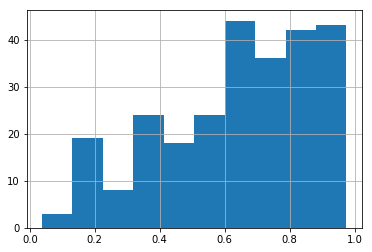

In [21]:
beatles_tracks['valence'].hist()

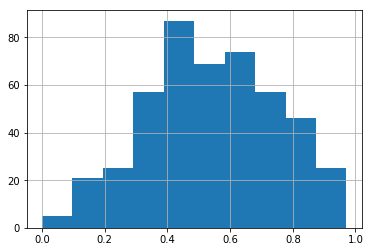

In [22]:
stones_tracks['valence'].hist()

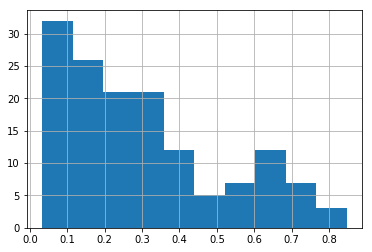

In [23]:
radiohead_tracks['valence'].hist()

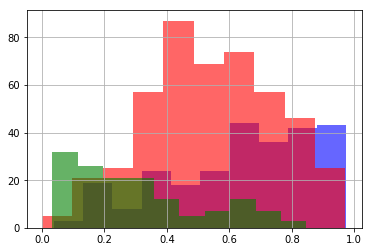

In [24]:
beatles_tracks['valence'].hist(alpha=0.6, color='blue')
stones_tracks['valence'].hist(alpha=0.6, color='red')
radiohead_tracks['valence'].hist(alpha=0.6, color='green')

In [31]:
tracks.find({'artist_id': stones_id, 'valence': {'$exists': True}}).count()

275

## Lyrics search<a name="lyricssearch"></a>
Now to find the lyrics for each track. 

We start by searching for the Genius ID for the artists.

Note that Genius doesn't like Python-generated requests to its API, so we set the header to pretend to be a command-line `curl` request.

* [Top](#top)

In [25]:
def genius_artist_search(artist_name, per_page=20):
    query = urllib.parse.urlencode({'q': artist_name,
                                    'per_page': str(per_page)
                                   })
    headers = {'Accept': 'application/json',
               'Authorization': 'Bearer ' + config['genius']['token'],
               'User-Agent': 'curl/7.9.8 (i686-pc-linux-gnu) libcurl 7.9.8 (OpenSSL 0.9.6b) (ipv6 enabled)'}
    request = urllib.request.Request('https://api.genius.com/search?{}'.format(query), 
                                     headers=headers,
                                     method='GET')
    with urllib.request.urlopen(request) as f:
            response = json.loads(f.read().decode('utf-8'))
            return response

In [26]:
response = genius_artist_search('the beatles')
beatles_genius_id = [hit['result']['primary_artist']['id'] for hit in response['response']['hits']][0]
beatles_genius_id

586

In [27]:
response = genius_artist_search('rolling stones')
stones_genius_id = [hit['result']['primary_artist']['id'] for hit in response['response']['hits']][0]
stones_genius_id

774

In [28]:
response = genius_artist_search('radiohead')
radiohead_genius_id = [hit['result']['primary_artist']['id'] for hit in response['response']['hits']][0]
radiohead_genius_id

604

We can now get the song information for each track for each artist. Note that Genius keeps lots of things to do with artists, including sleeve notes and the like. We're just after the lyrics.

In [42]:
def genius_song_search(artist_id):
    songs = pd.DataFrame()
    page = 1
    while page:
        query = urllib.parse.urlencode({'page': page, 'per_page': 20})
        headers = {'Accept': 'application/json',
               'Authorization': 'Bearer ' + config['genius']['token'],
               'User-Agent': 'curl/7.9.8 (i686-pc-linux-gnu) libcurl 7.9.8 (OpenSSL 0.9.6b) (ipv6 enabled)'}
        request = urllib.request.Request('https://api.genius.com/artists/{id}/songs?{query}'.format(id=artist_id,
                                                                                               query=query), 
                                     headers=headers,
                                     method='GET')
        with urllib.request.urlopen(request) as f:
            response = json.loads(f.read().decode('utf-8'))
            page = response['response']['next_page']
            for song in response['response']['songs']:
                if song['path'].endswith('lyrics'):
                    song['_id'] = song['id']
                    genius_tracks.replace_one({'_id': song['id']}, song, upsert=True)

In [43]:
genius_song_search(beatles_genius_id)
genius_tracks.find().count()

1071

In [44]:
genius_song_search(stones_genius_id)
genius_tracks.find().count()

1071

In [44]:
genius_song_search(radiohead_genius_id)
genius_tracks.find().count()

1071

In [45]:
genius_tracks.find_one()

{'_id': 1497768,
 'annotation_count': 1,
 'api_path': '/songs/1497768',
 'full_title': 'All Together on the Wireless Machine by\xa0The\xa0Beatles',
 'header_image_thumbnail_url': 'https://images.genius.com/ad1f59e8a03be4eb521e88015d15d6e8.200x200x1.jpg',
 'header_image_url': 'https://images.genius.com/ad1f59e8a03be4eb521e88015d15d6e8.200x200x1.jpg',
 'id': 1497768,
 'lyrics_owner_id': 1549345,
 'path': '/The-beatles-all-together-on-the-wireless-machine-lyrics',
 'primary_artist': {'api_path': '/artists/586',
  'header_image_url': 'https://images.genius.com/b82dbb78926a812abfa10886ac84c1a8.1000x523x1.jpg',
  'id': 586,
  'image_url': 'https://images.genius.com/ad1f59e8a03be4eb521e88015d15d6e8.200x200x1.jpg',
  'is_meme_verified': False,
  'is_verified': False,
  'name': 'The Beatles',
  'url': 'https://genius.com/artists/The-beatles'},
 'pyongs_count': None,
 'song_art_image_thumbnail_url': 'https://images.genius.com/ad1f59e8a03be4eb521e88015d15d6e8.200x200x1.jpg',
 'stats': {'hot': Fal

In [46]:
gsongs = pd.DataFrame(list(genius_tracks.find()))
gsongs.T

,0,1,2,3,4,5,6,7,8,9,...,1061,1062,1063,1064,1065,1066,1067,1068,1069,1070
_id,1497768,210315,123533,123537,117722,210284,1336394,107915,1308579,123808,...,310483,313269,313043,2389345,1245984,311907,310293,310289,106069,310543
annotation_count,1,1,5,4,6,1,1,6,1,1,...,1,1,1,4,1,1,4,1,16,15
api_path,/songs/1497768,/songs/210315,/songs/123533,/songs/123537,/songs/117722,/songs/210284,/songs/1336394,/songs/107915,/songs/1308579,/songs/123808,...,/songs/310483,/songs/313269,/songs/313043,/songs/2389345,/songs/1245984,/songs/311907,/songs/310293,/songs/310289,/songs/106069,/songs/310543
ctitle,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
full_title,All Together on the Wireless Machine by The Be...,A Little Rhyme by The Beatles (Ft. John & Rodn...,And I Love Her by The Beatles,Any Time at All by The Beatles,A Taste of Honey by The Beatles,Beatle Greetings by The Beatles (Ft. George Ha...,Can You Take Me Back by The Beatles,Carry That Weight by The Beatles,Down in Eastern Australia by The Beatles,Everybody's Trying to Be My Baby by The Beatles,...,You Can't Catch Me by The Rolling Stones,You Don't Have To Mean It by The Rolling Stones,You Got Me Rocking by The Rolling Stones,You Got the Silver by The Rolling Stones (Ft. ...,Don't Look Back by The Rolling Stones,Each and every day of the year by The Rolling ...,I'm A King Bee by The Rolling Stones,Little By Little by The Rolling Stones,Brown Sugar by The Rolling Stones,Citadel by The Rolling Stones
header_image_thumbnail_url,https://images.genius.com/ad1f59e8a03be4eb521e...,https://s3.amazonaws.com/rapgenius/110537_cda_...,https://images.genius.com/68c11c7f5b6b66194d77...,https://images.genius.com/68c11c7f5b6b66194d77...,https://s3.amazonaws.com/rapgenius/1360709432_...,https://s3.amazonaws.com/rapgenius/110537_cda_...,https://images.genius.com/ad1f59e8a03be4eb521e...,https://images.genius.com/560d707ac51a528c952d...,https://images.genius.com/ad1f59e8a03be4eb521e...,https://images.genius.com/4268a08d2b36372eb6e8...,...,https://images.genius.com/9c0263f14c39b6df59e5...,https://images.genius.com/eb7fd9257058b77179cb...,https://images.genius.com/a8ed1f93846da84943a7...,https://images.rapgenius.com/ac969979ccb91a0d2...,https://images.genius.com/23bbf05f7ee8286a8905...,https://images.genius.com/6c322c96140487d56076...,https://images.genius.com/076d49bcc219432b68b4...,https://images.genius.com/076d49bcc219432b68b4...,https://images.genius.com/5b7d4f11893ff2fdeba7...,https://images.genius.com/31323212a74c2a8d99eb...
header_image_url,https://images.genius.com/ad1f59e8a03be4eb521e...,https://s3.amazonaws.com/rapgenius/110537_cda_...,https://images.genius.com/68c11c7f5b6b66194d77...,https://images.genius.com/68c11c7f5b6b66194d77...,https://s3.amazonaws.com/rapgenius/1360709432_...,https://s3.amazonaws.com/rapgenius/110537_cda_...,https://images.genius.com/ad1f59e8a03be4eb521e...,https://images.genius.com/560d707ac51a528c952d...,https://images.genius.com/ad1f59e8a03be4eb521e...,https://images.genius.com/4268a08d2b36372eb6e8...,...,https://images.genius.com/9c0263f14c39b6df59e5...,https://images.genius.com/eb7fd9257058b77179cb...,https://images.genius.com/a8ed1f93846da84943a7...,https://images.rapgenius.com/ac969979ccb91a0d2...,https://images.genius.com/23bbf05f7ee8286a8905...,https://images.genius.com/6c322c96140487d56076...,https://images.genius.com/076d49bcc219432b68b4...,https://images.genius.com/076d49bcc219432b68b4...,https://images.genius.com/5b7d4f11893ff2fdeba7...,https://images.genius.com/31323212a74c2a8d99eb...
id,1497768,210315,123533,123537,117722,210284,1336394,107915,1308579,123808,...,310483,313269,313043,2389345,1245984,311907,310293,310289,106069,310543
lyrics,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lyrics_owner_id,1549345,250962,46871,46871,70799,250962,1549345,116340,1549345,22533,...,354383,354608,354382,1217557,1549345,354385,354383,354383,16,354608


Now we can get the lyrics for each song. We tidy it up as we go, to strip out formatting and the like.

Note the use of [Beautiful Soup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) to strip out the HTML from the lyrics.

In [30]:
def genius_lyrics(song_url):
    headers = {'Accept': 'application/json',
               'Authorization': 'Bearer ' + config['genius']['token'],
               'User-Agent': 'curl/7.9.8 (i686-pc-linux-gnu) libcurl 7.9.8 (OpenSSL 0.9.6b) (ipv6 enabled)'}
    request = urllib.request.Request(song_url, headers=headers, method='GET')
    html_doc = urllib.request.urlopen(request)
    soup = BeautifulSoup(html_doc, 'html.parser')
#     lyrics = soup.find('lyrics').get_text()
    if soup.find('div', class_='lyrics'):
        lyrics = soup.find('div', class_='lyrics').get_text()
    else:
        lyrics = ''
    return sanitise_lyrics(lyrics)

In [31]:
def sanitise_lyrics(lyrics):
    l2 = re.sub('\[[^\]]*\]', '', lyrics)
    l3 = re.sub('\[|\]', '', l2)
    l4 = re.sub('(\s)+', ' ', l3)
    l5 = re.sub('[,.!?;:]', '', l4)
    return l5.strip().lower(), lyrics

In [32]:
assl = genius_lyrics('https://genius.com/The-beatles-aint-she-sweet-lyrics')
assl

("oh ain't she sweet well see her walking down that street yes i ask you very confidentially ain't she sweet oh ain't she nice well look her over once or twice yes i ask you very confidentially ain't she nice just cast an eye in her direction oh me oh my ain't that perfection oh i repeat well don't you think that's kind of neat yes i ask you very confidentially ain't she sweet oh ain't she sweet well see her walking down that street yes i ask you very confidentially ain't she sweet oh ain't she nice well look her over once or twice yes i ask you very confidentially ain't she nice just cast an eye in her direction oh me oh my ain't that perfection oh i repeat well don't you think that's kind of neat yes i ask you very confidentially ain't she sweet oh ain't she sweet well see her walking down that street well i ask you very confidentially ain't she sweet well i ask you very confidentially ain't she sweet",
 "\n\n[Chorus 1]\nOh ain't she sweet\nWell see her walking down that street\nYes 

In [54]:
for gsong in genius_tracks.find():
    if 'lyrics' not in gsong:
        lyrics, original_lyrics = genius_lyrics(gsong['url'])
        genius_tracks.update_one({'_id': gsong['_id']}, 
                                 {'$set': {'lyrics': lyrics, 'original_lyrics': original_lyrics}})
genius_tracks.find_one({}, ['title', 'lyrics', 'original_lyrics'])

{'_id': 1497768,
 'lyrics': 'when i was sitting on my piano one day a magical thought came my way to write a number for the bbc kenny everett mccartney all together on the wireless machine kenny everett mccartney all together on the wireless machine kenny everett mccartney all together on the wireless machine',
 'original_lyrics': '\n\nWhen I was sitting on my piano one day\nA magical thought came my way\nTo write a number for the BBC\nKenny Everett McCartney\nAll together on the wireless machine\nKenny Everett McCartney\nAll together on the wireless machine\nKenny Everett McCartney\nAll together on the wireless machine\n\n',
 'title': 'All Together on the Wireless Machine'}

In [55]:
genius_tracks.create_index([('original_lyrics', pymongo.TEXT)])

'original_lyrics_text'

In [56]:
[t['original_lyrics'] for t in genius_tracks.find({'$text': {'$search': 'chorus'}}, limit=10)]

["\n\nClaudine's back in jail again\nClaudine's back in jail (again)\nClaudine's back in jail again\nClaudine\n\nClaudine's back in jail again\nClaudine's back in jail (again)\nShe only does it at weekends\nClaudine\nOh, Claudine\n\nNow only Spider knows for sure\nBut he ain't talkin' about it any more\nIs he, Claudine?\n\nThere's blood in the chalet\nAnd blood in the snow\n(She)Washed her hands of the whole damn show\nThe best thing you could do, Claudine\n\nShot him once right through the head\nShot him twice right through the chest\nThe judge says (ruled) it was an accident\nClaudine\nAccidents will happen\n(In the best homes)\n\nAnd Claudine's back in jail again\nClaudine's back in jail again\nClaudine's back in jail again\nClaudine\n\n(Claudine's back in jail again\nClaudine's back in jail again\nClaudine's back in jail again\n\nClaudine) (additional chorus)\nI'll tell you something\nNow Claudine's back in jail again\nClaudine's back in jail again\nClaudine's back in jail again\nC

## Matching datasets<a name="matchingdatasets"></a>
Now it's time to match up the datasets. First, we simplify the titles of the tracks, to sidestep differences in punctuation, capitalisation, and the like.

* [Top](#top)

In [57]:
def canonical_name(text):
    t1 = re.sub(' - .*', '', text) # Strip the " - Remastered 2015" suffix
    t2 = re.sub('[^\w\s]', '', t1) # strip all characters except letters, numbers, and whitespace
    t3 = re.sub('\s+', ' ', t2) # collapse whitespace
    return t3.lower() # convert to lowercase and return

In [58]:
canonical_name("A Hard Day's Night - Live / Remastered")

'a hard days night'

Add the simplified title to each track in the Spotify and Genius collections.

In [59]:
for t in tracks.find():
    tracks.update_one({'_id': t['_id']}, {'$set': {'ctitle': canonical_name(t['name'])}})
for t in genius_tracks.find():
    genius_tracks.update_one({'_id': t['_id']}, {'$set': {'ctitle': canonical_name(t['title'])}})

In [60]:
ctitles = set([t['ctitle'] for t in tracks.find()])

[(ct, [t['name'] for t in tracks.find({'ctitle': ct})]) 
 for ct in ctitles
 if tracks.find({'ctitle': ct}).count() > 1
]

[('you cant always get what you want',
  ['You Can’t Always Get What You Want - Live',
   "You Can't Always Get What You Want - Live Licks Tour - 2009 Re-Mastered Digital Version",
   "You Can't Always Get What You Want - Live / Remastered 2009",
   'You Can’t Always Get What You Want - Live']),
 ('next time you see me',
  ['Next Time You See Me - Live', 'Next Time You See Me - Live']),
 ('fixing a hole',
  ['Fixing A Hole - Remastered',
   'Fixing A Hole - Remix',
   'Fixing A Hole - Speech And Take 3']),
 ('harlem shuffle', ['Harlem Shuffle', 'Harlem Shuffle - Remastered']),
 ('back to zero', ['Back To Zero', 'Back To Zero - Remastered']),
 ('sgt peppers lonely hearts club band',
  ["Sgt. Pepper's Lonely Hearts Club Band - Remastered",
   "Sgt. Pepper's Lonely Hearts Club Band - Reprise / Remastered",
   "Sgt. Pepper's Lonely Hearts Club Band - Remix",
   "Sgt. Pepper's Lonely Hearts Club Band - Take 9 And Speech"]),
 ('im free',
  ["I'm Free - Live At The Beacon Theatre, New York / 

In [61]:
ctitles = set([t['ctitle'] for t in tracks.find()])

[(ct, [(t['name'], t['liveness']) for t in tracks.find({'ctitle': ct, 'liveness': {'$lt': 0.7}})]) 
 for ct in ctitles
 if tracks.find({'ctitle': ct, 'liveness': {'$lt': 0.7}}).count() > 1
]

[('you cant always get what you want',
  [('You Can’t Always Get What You Want - Live', 0.409),
   ("You Can't Always Get What You Want - Live / Remastered 2009", 0.419)]),
 ('fixing a hole',
  [('Fixing A Hole - Remastered', 0.0783),
   ('Fixing A Hole - Remix', 0.0678),
   ('Fixing A Hole - Speech And Take 3', 0.0437)]),
 ('harlem shuffle',
  [('Harlem Shuffle', 0.224), ('Harlem Shuffle - Remastered', 0.319)]),
 ('back to zero',
  [('Back To Zero', 0.064), ('Back To Zero - Remastered', 0.0767)]),
 ('lies', [('Lies - Remastered', 0.524), ('Lies - Remastered', 0.472)]),
 ('get back',
  [('Get Back - Remastered 2015', 0.0959), ('Get Back - Remastered', 0.61)]),
 ('roll over beethoven',
  [('Roll Over Beethoven - Saturday Club / 1963', 0.316),
   ('Roll Over Beethoven - Live / Remastered', 0.634),
   ('Roll Over Beethoven - Remastered', 0.0952)]),
 ('dirty work', [('Dirty Work', 0.0878), ('Dirty Work - Remastered', 0.0808)]),
 ('all you need is love',
  [('All You Need Is Love - Remaster

In [62]:
[(t['ctitle'], t['name'], g['title']) 
 for t in tracks.find()
 for g in genius_tracks.find({'ctitle': t['ctitle']})
 if genius_tracks.find({'ctitle': t['ctitle']}).count() > 1]

[('sweet little sixteen',
  'Sweet Little Sixteen - Live',
  'Sweet Little Sixteen'),
 ('sweet little sixteen',
  'Sweet Little Sixteen - Live',
  'Sweet Little Sixteen'),
 ('roll over beethoven',
  'Roll Over Beethoven - Saturday Club / 1963',
  'Roll Over Beethoven'),
 ('roll over beethoven',
  'Roll Over Beethoven - Saturday Club / 1963',
  'Roll Over Beethoven'),
 ('memphis tennessee',
  'Memphis, Tennessee - Saturday Club / 1963',
  'Memphis, Tennessee'),
 ('memphis tennessee',
  'Memphis, Tennessee - Saturday Club / 1963',
  'Memphis Tennessee'),
 ('i wanna be your man',
  'I Wanna Be Your Man - Saturday Club / 1964',
  'I Wanna Be Your Man'),
 ('i wanna be your man',
  'I Wanna Be Your Man - Saturday Club / 1964',
  'I Wanna Be Your Man'),
 ('carol', 'Carol - Saturday Club / 1964', 'Carol'),
 ('carol', 'Carol - Saturday Club / 1964', 'Carol'),
 ('little by little',
  'Little By Little - The Joe Loss Pop Show / 1964',
  'Little by Little'),
 ('little by little',
  'Little By Litt

Now to see what the differences are. Find the tracks that are in both collections, and tracks that are in only one.

In [63]:
in_both = set((g['ctitle'], g['primary_artist']['name'])
              for g in genius_tracks.find({}, ['ctitle', 'primary_artist.name']) 
              if tracks.find({'ctitle': g['ctitle']}).count())

genius_only = set((g['ctitle'], g['primary_artist']['name']) 
                  for g in genius_tracks.find({}, ['ctitle', 'primary_artist.name']) 
                  if not tracks.find({'ctitle': g['ctitle']}).count())

spotify_only = set((s['ctitle'], s['artist_name'])
                   for s in tracks.find({}, ['ctitle', 'artist_name']) 
                   if not genius_tracks.find({'ctitle': s['ctitle']}).count())

len(in_both), len(genius_only), len(spotify_only)

(541, 521, 107)

In [64]:
[s for s in spotify_only 
 if 'rmx' not in s[0]
 if 'remix' not in s[0]
 if 'live' not in s[0]
 if 'intro' not in s[0]
]

[('if u cant dance', 'Spice Girls'),
 ('champagne and reefer', 'The Rolling Stones'),
 ('key to the highway', 'The Rolling Stones'),
 ('stop', 'Spice Girls'),
 ('right back at ya', 'Spice Girls'),
 ('you dont have to go', 'Muddy Waters'),
 ('let love lead the way', 'Spice Girls'),
 ('county jail', 'Muddy Waters'),
 ('trouble no more', 'Muddy Waters'),
 ('time goes by', 'Spice Girls'),
 ('little ta', 'The Rolling Stones'),
 ('pepperland', 'George Martin'),
 ('you got me rockin', 'The Rolling Stones'),
 ('sea of holes', 'George Martin'),
 ('next time you see me', 'The Rolling Stones'),
 ('something kinda funny', 'Spice Girls'),
 ('untitled', 'Radiohead'),
 ('if you wanna have some fun', 'Spice Girls'),
 ('wasting my time', 'Spice Girls'),
 ('packt like sardines in a crushed tin box', 'Radiohead'),
 ('do it', 'Spice Girls'),
 ('march of the meanies', 'George Martin'),
 ('codex illum sphere', 'Radiohead'),
 ('spice up your life', 'Spice Girls'),
 ('oxygen', 'Spice Girls'),
 ('the lady is a

In [65]:
[g for g in genius_only
 if 'take' not in g[0]
 if 'medley' not in g[0]
 if 'intro' not in g[0]
 if 'live' not in g[0]
]

[('sha la la la la', 'The Beatles'),
 ('susie q', 'The Rolling Stones'),
 ('nobodys child', 'The Beatles'),
 ('prodigal son', 'The Rolling Stones'),
 ('come and get it', 'The Beatles'),
 ('surprise surprise', 'The Rolling Stones'),
 ('i promise', 'Radiohead'),
 ('keep your hands off my baby', 'The Beatles'),
 ('four guys', 'James Richards'),
 ('so divine aladdin story', 'The Rolling Stones'),
 ('punchdrunk lovesick singalong', 'Radiohead'),
 ('im talking about you', 'The Beatles'),
 ('bebopalula', 'The Beatles'),
 ('gangsters maul', 'The Rolling Stones'),
 ('the daily mail', 'Radiohead'),
 ('plundered my soul', 'The Rolling Stones'),
 ('i need you baby mona', 'The Rolling Stones'),
 ('clarabella', 'The Beatles'),
 ('everyone needs someone to hate', 'On A Friday'),
 ('what is that you say', 'Radiohead'),
 ('i call your name', 'The Beatles'),
 ('congratulations', 'The Rolling Stones'),
 ('tell me', 'The Rolling Stones'),
 ('gotta get away', 'The Rolling Stones'),
 ('empty heart', 'The Ro

In [66]:
[t for t in genius_only if 'revolution' in t[0]]

[('revolution i', 'The Beatles'), ('revolution', 'The Beatles')]

In [67]:
[t for t in spotify_only if 'revolution' in t[0]]

[('revolution 1', 'The Beatles')]

In [68]:
([t for t in in_both if 'jack flash' in t], [t for t in spotify_only if 'jack flash' in t[0]])

([], [('jumping jack flash', 'The Rolling Stones')])

In [69]:
for ct in ctitles:
    sts = [(t['ctitle'], t['artist_name']) for t in tracks.find({'ctitle': ct}, ['ctitle', 'artist_name'])]
    gts = [(t['ctitle'], t['primary_artist']['name']) for t in genius_tracks.find({'ctitle': ct}, ['ctitle', 'primary_artist.name'])]
    if len(sts) != 1 or len(gts) != 1:
        print(ct, sts, gts)

you cant always get what you want [('you cant always get what you want', 'The Rolling Stones'), ('you cant always get what you want', 'The Rolling Stones'), ('you cant always get what you want', 'The Rolling Stones'), ('you cant always get what you want', 'The Rolling Stones')] [('you cant always get what you want', 'The Rolling Stones')]
next time you see me [('next time you see me', 'The Rolling Stones'), ('next time you see me', 'The Rolling Stones')] []
fixing a hole [('fixing a hole', 'The Beatles'), ('fixing a hole', 'The Beatles'), ('fixing a hole', 'The Beatles')] [('fixing a hole', 'The Beatles')]
who do you think you are [('who do you think you are', 'Spice Girls')] []
harlem shuffle [('harlem shuffle', 'The Rolling Stones'), ('harlem shuffle', 'The Rolling Stones')] [('harlem shuffle', 'The Rolling Stones')]
back to zero [('back to zero', 'The Rolling Stones'), ('back to zero', 'The Rolling Stones')] [('back to zero', 'The Rolling Stones')]
sgt peppers lonely hearts club ban

you got me rockin [('you got me rockin', 'The Rolling Stones'), ('you got me rockin', 'The Rolling Stones')] []
sea of monsters [('sea of monsters', 'George Martin')] []
things we said today [('things we said today', 'The Beatles'), ('things we said today', 'The Beatles')] [('things we said today', 'The Beatles')]
pepperland [('pepperland', 'George Martin')] []
being for the benefit of mr kite [('being for the benefit of mr kite', 'The Beatles'), ('being for the benefit of mr kite', 'The Beatles'), ('being for the benefit of mr kite', 'The Beatles')] [('being for the benefit of mr kite', 'The Beatles')]
had it with you [('had it with you', 'The Rolling Stones'), ('had it with you', 'The Rolling Stones')] [('had it with you', 'The Rolling Stones')]
true love waits live in oslo [('true love waits live in oslo', 'Radiohead')] []
bloom jamie xx rework [('bloom jamie xx rework', 'Radiohead')] []
sweet little angel [('sweet little angel', 'Muddy Waters')] []
separator anstam rmx [('separator

its only rock n roll but i like it [('its only rock n roll but i like it', 'The Rolling Stones'), ('its only rock n roll but i like it', 'The Rolling Stones'), ('its only rock n roll but i like it', 'The Rolling Stones')] [('its only rock n roll but i like it', 'The Rolling Stones')]
bloom objekt rmx [('bloom objekt rmx', 'Radiohead')] []
untitled [('untitled', 'Radiohead')] []
sea of holes [('sea of holes', 'George Martin')] []
when the whip comes down [('when the whip comes down', 'Bob Clearmountain'), ('when the whip comes down', 'The Rolling Stones'), ('when the whip comes down', 'The Rolling Stones'), ('when the whip comes down', 'The Rolling Stones'), ('when the whip comes down', 'The Rolling Stones')] [('when the whip comes down', 'The Rolling Stones')]
codex illum sphere [('codex illum sphere', 'Radiohead')] []
monkey man [('monkey man', 'The Rolling Stones'), ('monkey man', 'The Rolling Stones')] [('monkey man', 'The Rolling Stones')]
give up the ghost thriller houseghost remi

black limousine [('black limousine', 'The Rolling Stones'), ('black limousine', 'The Rolling Stones')] [('black limousine', 'The Rolling Stones')]
out of control [('out of control', 'The Rolling Stones'), ('out of control', 'The Rolling Stones')] [('out of control', 'The Rolling Stones')]
dizzy miss lizzy [('dizzy miss lizzy', 'The Beatles'), ('dizzy miss lizzy', 'The Beatles')] [('dizzy miss lizzy', 'The Beatles')]
little by little caribou rmx [('little by little caribou rmx', 'Radiohead')] []
dollars cents live [('dollars cents live', 'Radiohead')] []
you cant do that [('you cant do that', 'The Beatles'), ('you cant do that', 'The Beatles')] [('you cant do that', 'The Beatles')]
trouble no more [('trouble no more', 'Muddy Waters')] []
with a little help from my friends [('with a little help from my friends', 'The Beatles'), ('with a little help from my friends', 'The Beatles'), ('with a little help from my friends', 'The Beatles')] [('with a little help from my friends', 'The Beatles

In [70]:
def levenshtein(s1, s2):
    if len(s1) < len(s2):
        return levenshtein(s2, s1)

    # len(s1) >= len(s2)
    if len(s2) == 0:
        return len(s1)

    previous_row = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        current_row = [i + 1]
        for j, c2 in enumerate(s2):
            insertions = previous_row[j + 1] + 1 # j+1 instead of j since previous_row and current_row are one character longer
            deletions = current_row[j] + 1       # than s2
            substitutions = previous_row[j] + (c1 != c2)
            current_row.append(min(insertions, deletions, substitutions))
        previous_row = current_row
    
    return previous_row[-1]

In [71]:
banned_substrings = ['rmx', 'remix', 'rework', 'live', 'intro', 'medley']
genius_and_both = genius_only | in_both
for s in spotify_only:
    if not any(banned in s[0] for banned in banned_substrings):
        candidates = [g for g in genius_and_both if g[1] == s[1]]
        if candidates:
            gt = min(candidates, key=lambda g: levenshtein(s[0], g[0]))
            d = levenshtein(s[0], gt[0])
        else:
            gt = 'Missing'
            d = 99999
        print(s, gt, d, gt in in_both)

('if u cant dance', 'Spice Girls') Missing 99999 False
('champagne and reefer', 'The Rolling Stones') ('champagne reefer', 'The Rolling Stones') 4 True
('key to the highway', 'The Rolling Stones') ('thief in the night', 'The Rolling Stones') 10 True
('stop', 'Spice Girls') Missing 99999 False
('right back at ya', 'Spice Girls') Missing 99999 False
('you dont have to go', 'Muddy Waters') Missing 99999 False
('let love lead the way', 'Spice Girls') Missing 99999 False
('county jail', 'Muddy Waters') Missing 99999 False
('trouble no more', 'Muddy Waters') Missing 99999 False
('time goes by', 'Spice Girls') Missing 99999 False
('little ta', 'The Rolling Stones') ('little t a', 'The Rolling Stones') 1 False
('pepperland', 'George Martin') ('yellow submarine in pepperland', 'George Martin') 20 True
('you got me rockin', 'The Rolling Stones') ('you got me rocking', 'The Rolling Stones') 1 True
('sea of holes', 'George Martin') ('yellow submarine in pepperland', 'George Martin') 25 True
('next

In [73]:
genius_and_both = genius_only | in_both
for s in spotify_only:
    if 'rmx' not in s[0] and 'remix' not in s[0] and 'live' not in s[0]:
#         album = 
        candidates = [g for g in genius_and_both if g[1] == s[1]]
        if candidates:
            gts = [(g, levenshtein(s[0], g[0])) for g in candidates if levenshtein(s[0], g[0]) < 5]
            print(s, gts)

('champagne and reefer', 'The Rolling Stones') [(('champagne reefer', 'The Rolling Stones'), 4)]
('key to the highway', 'The Rolling Stones') []
('little ta', 'The Rolling Stones') [(('little baby', 'The Rolling Stones'), 3), (('little t a', 'The Rolling Stones'), 1), (('little rain', 'The Rolling Stones'), 3), (('title 5', 'The Rolling Stones'), 4)]
('pepperland', 'George Martin') []
('you got me rockin', 'The Rolling Stones') [(('you got me rocking', 'The Rolling Stones'), 1)]
('sea of holes', 'George Martin') []
('next time you see me', 'The Rolling Stones') []
('untitled', 'Radiohead') []
('packt like sardines in a crushed tin box', 'Radiohead') [(('packt like sardines in a crushd tin box', 'Radiohead'), 1)]
('march of the meanies', 'George Martin') []
('codex illum sphere', 'Radiohead') []
('charlies intro to little red rooster', 'The Rolling Stones') []
('instrumental 1', 'The Rolling Stones') []
('long distance call', 'The Rolling Stones') []
('one eyed woman', 'The Rolling Ston

In [74]:
pd.DataFrame(list(albums.find({}, ['artist_name', 'name'])))

,_id,artist_name,name
0,5XfJmldgWzrc1AIdbBaVZn,The Beatles,Live At The Hollywood Bowl
1,5ju5Ouzan3QwXqQt1Tihbh,The Beatles,1 (Remastered)
2,2pCqZLeavM2BMovJXsJEIV,The Beatles,Let It Be (Remastered)
3,2Pqkn9Dq2DFtdfkKAeqgMd,The Beatles,Abbey Road (Remastered)
4,47bcKzmKgmMPHXNVOWpLiu,The Beatles,Yellow Submarine (Remastered)
5,03Qh833fEdVT30Pfs93ea6,The Beatles,The Beatles (Remastered)
6,6P9yO0ukhOx3dvmhGKeYoC,The Beatles,Magical Mystery Tour (Remastered)
7,1PULmKbHeOqlkIwcDMNwD4,The Beatles,Sgt. Pepper's Lonely Hearts Club Band (Remaste...
8,0PYyrqs9NXtxPhf0CZkq2L,The Beatles,Revolver (Remastered)
9,3OdI6e43crvyAHhaqpxSyz,The Beatles,Rubber Soul (Remastered)


Manually fix a couple of errors.

In [75]:
genius_tracks.update_many({'ctitle': 'revolution i'}, 
                          {'$set': {'ctitle': 'revolution 1'}})
genius_tracks.update_many({'ctitle': 'when im sixtyfour'}, 
                          {'$set': {'ctitle': 'when im sixty four'}})
genius_tracks.update_many({'ctitle': 'packt like sardines in a crushd tin box'}, 
                          {'$set': {'ctitle': 'packt like sardines in a crushed tin box'}})
genius_tracks.update_many({'ctitle': 'a punchup at a wedding'}, 
                          {'$set': {'ctitle': 'a punch up at a wedding'}})
genius_tracks.update_many({'ctitle': 'dollars cents'}, 
                          {'$set': {'ctitle': 'dollars and cents'}})
genius_tracks.update_many({'ctitle': 'bullet proofi wish i was'}, 
                          {'$set': {'ctitle': 'bullet proof i wish i was'}})
genius_tracks.update_many({'ctitle': 'jumpin jack flash'}, 
                          {'$set': {'ctitle': 'jumping jack flash'}})
genius_tracks.update_many({'ctitle': 'far away eyes'}, 
                          {'$set': {'ctitle': 'faraway eyes'}})

In [76]:
in_both = set(g['ctitle'] for g in genius_tracks.find({}, ['ctitle']) if tracks.find({'ctitle': g['ctitle']}).count())
genius_only = set(g['ctitle'] for g in genius_tracks.find({}, ['ctitle']) if not tracks.find({'ctitle': g['ctitle']}).count())
spotify_only = set(s['ctitle'] for s in tracks.find({}, ['ctitle']) if not genius_tracks.find({'ctitle': s['ctitle']}).count())
len(in_both), len(genius_only), len(spotify_only)

(532, 516, 103)

### Copy the lyrics over<a name="copylyrics"></a>
Now can can connect the tracks, let's copy across the lyrics from the Genius collection into the Spotify collection. We'll calculate the lyrical density at the same time.

* [Top](#top)

In [77]:
for t in tracks.find({}, ['ctitle', 'duration_ms']):
    gts = genius_tracks.find({'ctitle': t['ctitle'], 'lyrics': {'$exists': True}}, ['lyrics', 'original_lyrics'])
    for gt in gts:
        tracks.update_one({'_id': t['_id']}, 
                          {'$set': {'lyrics': gt['lyrics'], 
                                    'original_lyrics': gt['original_lyrics'],
                                    'lyrical_density': 1000 * len(gt['lyrics'].split()) / t['duration_ms']}})

## Sentiment analysis<a name="sentimentanalysis"></a>
I couldn't find an easily-installable equivalent to the NRC corpus, so I'm using a sentiment analysis API endpoint from [Text Processing](http://text-processing.com/docs/sentiment.html).

* [Top](#top)

In [78]:
for t in tracks.find({'lyrics': {'$exists': True}}, ['lyrics']):
    text = t['lyrics']
    if text:
        query = urllib.parse.urlencode({'text': text}).encode('ascii')
        headers = {'Accept': 'application/json',
                   'User-Agent': 'curl/7.9.8 (i686-pc-linux-gnu) libcurl 7.9.8 (OpenSSL 0.9.6b) (ipv6 enabled)'}
        request = urllib.request.Request('http://text-processing.com/api/sentiment/', 
                                 headers=headers, data=query)
        with urllib.request.urlopen(request) as f:
            response = json.loads(f.read().decode('utf-8'))
            tracks.update_one({'_id': t['_id']}, {'$set': {'sentiment': response}})

In [79]:
tracks.find_one({'sentiment': {'$exists': True}}).keys()

dict_keys(['explicit', 'artist_name', 'lyrics', 'uri', 'track_number', 'mode', 'album_id', '_id', 'preview_url', 'acousticness', 'liveness', 'energy', 'disc_number', 'valence', 'artist_id', 'lyrical_density', 'ctitle', 'popularity', 'original_lyrics', 'speechiness', 'sentiment', 'loudness', 'href', 'available_markets', 'type', 'name', 'external_ids', 'artists', 'id', 'key', 'instrumentalness', 'album', 'time_signature', 'danceability', 'duration_ms', 'tempo', 'external_urls', 'analysis_url', 'track_href'])

In [80]:
tracks.find_one({'sentiment': {'$exists': True}})

{'_id': '1jgefM2ZP7RnPVShhy1eUM',
 'acousticness': 0.148,
 'album': {'album_type': 'album',
  'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/22bE4uQ6baNwSHPVcDxLCe'},
    'href': 'https://api.spotify.com/v1/artists/22bE4uQ6baNwSHPVcDxLCe',
    'id': '22bE4uQ6baNwSHPVcDxLCe',
    'name': 'The Rolling Stones',
    'type': 'artist',
    'uri': 'spotify:artist:22bE4uQ6baNwSHPVcDxLCe'}],
  'available_markets': ['GB'],
  'external_urls': {'spotify': 'https://open.spotify.com/album/3PbRKFafwE7Of8e4dTee72'},
  'href': 'https://api.spotify.com/v1/albums/3PbRKFafwE7Of8e4dTee72',
  'id': '3PbRKFafwE7Of8e4dTee72',
  'images': [{'height': 640,
    'url': 'https://i.scdn.co/image/4bd988736fe53e8109488f0f390cdfd5d119762d',
    'width': 640},
   {'height': 300,
    'url': 'https://i.scdn.co/image/b5c53642ccdaac3120aa766ce5e29d9c1b61794f',
    'width': 300},
   {'height': 64,
    'url': 'https://i.scdn.co/image/9c6e2872cbd2688c528d5d43c57651d12c19eec1',
    'width': 64}],
  

In [81]:
tracks.find({'sentiment': {'$exists': True}}).count(), tracks.find({'sentiment': {'$exists': False}}).count()

(790, 134)

In [82]:
tracks.find({'sentiment': {'$exists': False}, 'lyrics': {'$exists': True}}).count()

8

In [83]:
pd.DataFrame(list(tracks.find({'sentiment': {'$exists': False}, 
                               'lyrics': {'$exists': True}}, 
                              ['name', 'artist_name', 'lyrics'])))

,_id,artist_name,lyrics,name
0,47DgFAFnhfwoSko23P7pz5,George Martin,,Yellow Submarine In Pepperland - Remastered
1,2z1p43SNSbeowzy8WdYHNk,The Beatles,,Flying - Remastered 2009
2,3gKuywOm38axM8sJGq6Laq,Radiohead,,MK 1
3,2uYSbsxAMmK1awUl06T7ix,Radiohead,,MK 2
4,1q6X5sJSWQ2QnqvPghR0Kr,Radiohead,,I Am Citizen Insane
5,4blz5SBUxKbtDNwMWstGNG,Radiohead,,Where Bluebirds Fly
6,2zYrFer4QGSQkk5aUawfHB,Radiohead,,Hunting Bears
7,4DPQvbgSM0IdX4O3HOACwL,Radiohead,,Treefingers


In [84]:
list(tracks.find({'sentiment': {'$exists': False}, 
                               'lyrics': {'$exists': True}}, 
                              ['name', 'artist_name', 'lyrics', 'original_lyrics']))

[{'_id': '47DgFAFnhfwoSko23P7pz5',
  'artist_name': 'George Martin',
  'lyrics': '',
  'name': 'Yellow Submarine In Pepperland - Remastered',
  'original_lyrics': '\n\n[Instrumental]\n\n'},
 {'_id': '2z1p43SNSbeowzy8WdYHNk',
  'artist_name': 'The Beatles',
  'lyrics': '',
  'name': 'Flying - Remastered 2009',
  'original_lyrics': '\n\n[Instrumental]\n\n'},
 {'_id': '3gKuywOm38axM8sJGq6Laq',
  'artist_name': 'Radiohead',
  'lyrics': '',
  'name': 'MK 1',
  'original_lyrics': '\n\n[Instrumental]\n\n'},
 {'_id': '2uYSbsxAMmK1awUl06T7ix',
  'artist_name': 'Radiohead',
  'lyrics': '',
  'name': 'MK 2',
  'original_lyrics': '\n\n[Instrumental]\n\n'},
 {'_id': '1q6X5sJSWQ2QnqvPghR0Kr',
  'artist_name': 'Radiohead',
  'lyrics': '',
  'name': 'I Am Citizen Insane',
  'original_lyrics': '\n\n[Instrumental]\n\n'},
 {'_id': '4blz5SBUxKbtDNwMWstGNG',
  'artist_name': 'Radiohead',
  'lyrics': '',
  'name': 'Where Bluebirds Fly',
  'original_lyrics': '\n\n[Distorted "Somewhere Over The Rainbow" lyric

In [85]:
tracks.update_many({'lyrics': ''}, {'$unset': {'lyrics': ''}})

In [86]:
pd.DataFrame(list(tracks.find({'sentiment': {'$exists': False}, 
                               'lyrics': {'$exists': True}}, 
                              ['name', 'artist_name', 'lyrics'])))

""


## Remove live and duplicate tracks<a name="removedupliates"></a>
We don't want to include tracks from live albums and tracks that appear more than once, such as on deluxe, remastered, and basic versions of albums.

There's no quick and easy way to do this, so this section is just a lot of faffing around. The upshot is that the tracks we want to ignore will end up with an `ignore: True` tag on them, and they will be filtered out in a view for the analysis later.

* [Top](#top)

In [87]:
pd.DataFrame(list(albums.find({}, ['name', 'artist_name', 'release_date'])))

,_id,artist_name,name,release_date
0,5XfJmldgWzrc1AIdbBaVZn,The Beatles,Live At The Hollywood Bowl,2016-09-09
1,5ju5Ouzan3QwXqQt1Tihbh,The Beatles,1 (Remastered),2000-11-13
2,2pCqZLeavM2BMovJXsJEIV,The Beatles,Let It Be (Remastered),1970-05-08
3,2Pqkn9Dq2DFtdfkKAeqgMd,The Beatles,Abbey Road (Remastered),1969-09-26
4,47bcKzmKgmMPHXNVOWpLiu,The Beatles,Yellow Submarine (Remastered),1969-01-17
5,03Qh833fEdVT30Pfs93ea6,The Beatles,The Beatles (Remastered),1968-11-22
6,6P9yO0ukhOx3dvmhGKeYoC,The Beatles,Magical Mystery Tour (Remastered),1967-11-27
7,1PULmKbHeOqlkIwcDMNwD4,The Beatles,Sgt. Pepper's Lonely Hearts Club Band (Remaste...,1967-06-01
8,0PYyrqs9NXtxPhf0CZkq2L,The Beatles,Revolver (Remastered),1966-08-05
9,3OdI6e43crvyAHhaqpxSyz,The Beatles,Rubber Soul (Remastered),1965-12-03


In [88]:
albums.find_one().keys()

dict_keys(['genres', 'artist_id', '_id', 'copyrights', 'album_type', 'available_markets', 'release_date_precision', 'label', 'type', 'name', 'images', 'uri', 'href', 'id', 'release_date', 'artist_name', 'tracks', 'external_ids', 'artists', 'external_urls', 'popularity'])

In [89]:
pd.DataFrame(list(tracks.find({'album_id': '5ju5Ouzan3QwXqQt1Tihbh'}, ['name', 'ctitle'])))

,_id,ctitle,name
0,5JT7CoUSGNk7mMNkHMQjqr,love me do,Love Me Do - Mono / Remastered
1,2Q2Gu7Bv8iLenuygtBgDUw,from me to you,From Me To You - Mono / Remastered
2,2Fk411Ix3qnMG8t8Qa74ZX,she loves you,She Loves You - Mono / Remastered
3,4DRBaZ760gyk7LWnaJFqsJ,i want to hold your hand,I Want To Hold Your Hand - Remastered 2015
4,7pQAq14Z73YUFMtxCyt0bG,cant buy me love,Can't Buy Me Love - Remastered 2015
5,0mNQUZEATk2uItMUtiLWK5,a hard days night,A Hard Day's Night - Remastered 2015
6,0Gm34HBxrXlaAf1jdJMjx2,i feel fine,I Feel Fine - Remastered 2015
7,3nhJDVdUrm6DnDW4iBfpKz,eight days a week,Eight Days A Week - Remastered 2015
8,6pkjW5srxjzRSKKMrl7et8,ticket to ride,Ticket To Ride - Remastered 2015
9,1dfuJYDSIc41cw5RPsaCF1,help,Help! - Remastered 2015


In [90]:
pd.DataFrame(list({'ctitle': t['ctitle'], 't_name': t['name'],
                  'tt_name': tt['name'], 'tt_alb': tt['album']['name']}
                  for t in tracks.find({'album_id': '5ju5Ouzan3QwXqQt1Tihbh'}, ['name', 'ctitle'])
                  for tt in tracks.find({'ctitle': t['ctitle']}, ['name', 'ctitle', 'album.name', 'album_id'])
                  if tt['album_id'] != '5ju5Ouzan3QwXqQt1Tihbh'))

,ctitle,t_name,tt_alb,tt_name
0,love me do,Love Me Do - Mono / Remastered,Please Please Me (Remastered),Love Me Do - Remastered 2009
1,she loves you,She Loves You - Mono / Remastered,Live At The Hollywood Bowl,She Loves You - Live / Remastered
2,i want to hold your hand,I Want To Hold Your Hand - Remastered 2015,Live At The Hollywood Bowl,I Want To Hold Your Hand - Live / Bonus Track
3,cant buy me love,Can't Buy Me Love - Remastered 2015,Live At The Hollywood Bowl,Can't Buy Me Love - Live / Remastered
4,cant buy me love,Can't Buy Me Love - Remastered 2015,A Hard Day's Night (Remastered),Can't Buy Me Love - Remastered
5,a hard days night,A Hard Day's Night - Remastered 2015,Live At The Hollywood Bowl,A Hard Day's Night - Live / Remastered
6,a hard days night,A Hard Day's Night - Remastered 2015,A Hard Day's Night (Remastered),A Hard Day's Night - Remastered
7,eight days a week,Eight Days A Week - Remastered 2015,Beatles For Sale (Remastered),Eight Days A Week - Remastered
8,ticket to ride,Ticket To Ride - Remastered 2015,Live At The Hollywood Bowl,Ticket To Ride - Live / Remastered
9,ticket to ride,Ticket To Ride - Remastered 2015,Help! (Remastered),Ticket To Ride - Remastered


In [91]:
pd.DataFrame(list({'ctitle': t['ctitle'], 't_name': t['name']}
                  for t in tracks.find({'album_id': '5ju5Ouzan3QwXqQt1Tihbh'}, ['name', 'ctitle'])
                  if len(list(tracks.find({'ctitle': t['ctitle'],
                                          'album_id': {'$ne': '5ju5Ouzan3QwXqQt1Tihbh' }}))) == 0))

,ctitle,t_name
0,from me to you,From Me To You - Mono / Remastered
1,i feel fine,I Feel Fine - Remastered 2015
2,day tripper,Day Tripper - Remastered 2015
3,we can work it out,We Can Work It Out - Remastered 2015
4,paperback writer,Paperback Writer - Remastered 2015
5,lady madonna,Lady Madonna - Remastered 2015
6,hey jude,Hey Jude - Remastered 2015
7,the ballad of john and yoko,The Ballad Of John And Yoko - Remastered 2015


In [92]:
[t for t in tracks.find({}, ['album.name', 'ctitle']) if 'jude' in  t['ctitle']]

[{'_id': '3H7sv3Krffn15BufUuXzf3',
  'album': {'name': '1 (Remastered)'},
  'ctitle': 'hey jude'}]

In [93]:
pd.DataFrame(list(tracks.find({'album_id': '5XfJmldgWzrc1AIdbBaVZn'}, ['name', 'ctitle'])))

,_id,ctitle,name
0,4edArG2VehvJdwOZfYOxtK,twist and shout,Twist And Shout - Live / Remastered
1,150EAeMGWJRubuH8zyx7h8,shes a woman,She's A Woman - Live / Remastered
2,1fVeHYkyMxrjbjRAD9uWsZ,dizzy miss lizzy,Dizzy Miss Lizzy - Live / Remastered
3,0GRplBEB2FWCKutwMmS6nY,ticket to ride,Ticket To Ride - Live / Remastered
4,1eVymk74iroqhsZxm0Vy3g,cant buy me love,Can't Buy Me Love - Live / Remastered
5,2p5a9gu6NECVSvBtGSU1vm,things we said today,Things We Said Today - Live / Remastered
6,1HyLh5cctOnP186CBi8bhm,roll over beethoven,Roll Over Beethoven - Live / Remastered
7,7fZEWm7TAL2oZDyiYrrgnk,boys,Boys - Live / Remastered
8,21nhooOxso7CCoHPE73w4L,a hard days night,A Hard Day's Night - Live / Remastered
9,1alcPfZWUHh01l4Fnoo5Jt,help,Help! - Live / Remastered


In [94]:
tracks.update_many({'album_id': '5XfJmldgWzrc1AIdbBaVZn'}, {'$set': {'ignore': True}})

In [95]:
pd.DataFrame(list(tracks.find({'album_id': '5XfJmldgWzrc1AIdbBaVZn'}, ['name', 'ctitle', 'ignore'])))

,_id,ctitle,ignore,name
0,4edArG2VehvJdwOZfYOxtK,twist and shout,True,Twist And Shout - Live / Remastered
1,150EAeMGWJRubuH8zyx7h8,shes a woman,True,She's A Woman - Live / Remastered
2,1fVeHYkyMxrjbjRAD9uWsZ,dizzy miss lizzy,True,Dizzy Miss Lizzy - Live / Remastered
3,0GRplBEB2FWCKutwMmS6nY,ticket to ride,True,Ticket To Ride - Live / Remastered
4,1eVymk74iroqhsZxm0Vy3g,cant buy me love,True,Can't Buy Me Love - Live / Remastered
5,2p5a9gu6NECVSvBtGSU1vm,things we said today,True,Things We Said Today - Live / Remastered
6,1HyLh5cctOnP186CBi8bhm,roll over beethoven,True,Roll Over Beethoven - Live / Remastered
7,7fZEWm7TAL2oZDyiYrrgnk,boys,True,Boys - Live / Remastered
8,21nhooOxso7CCoHPE73w4L,a hard days night,True,A Hard Day's Night - Live / Remastered
9,1alcPfZWUHh01l4Fnoo5Jt,help,True,Help! - Live / Remastered


In [96]:
pd.DataFrame(list({'ctitle': t['ctitle'], 't_name': t['name'],
                  'tt_name': tt['name'], 'tt_alb': tt['album']['name']}
                  for t in tracks.find({'album_id': '5XfJmldgWzrc1AIdbBaVZn'}, ['name', 'ctitle'])
                  for tt in tracks.find({'ctitle': t['ctitle'], 
                                         'album_id': {'$ne': '5XfJmldgWzrc1AIdbBaVZn'}}, 
                                        ['name', 'ctitle', 'album.name', 'album_id'])))

,ctitle,t_name,tt_alb,tt_name
0,twist and shout,Twist And Shout - Live / Remastered,Please Please Me (Remastered),Twist And Shout - Remastered 2009
1,dizzy miss lizzy,Dizzy Miss Lizzy - Live / Remastered,Help! (Remastered),Dizzy Miss Lizzy - Remastered
2,ticket to ride,Ticket To Ride - Live / Remastered,1 (Remastered),Ticket To Ride - Remastered 2015
3,ticket to ride,Ticket To Ride - Live / Remastered,Help! (Remastered),Ticket To Ride - Remastered
4,cant buy me love,Can't Buy Me Love - Live / Remastered,1 (Remastered),Can't Buy Me Love - Remastered 2015
5,cant buy me love,Can't Buy Me Love - Live / Remastered,A Hard Day's Night (Remastered),Can't Buy Me Love - Remastered
6,things we said today,Things We Said Today - Live / Remastered,A Hard Day's Night (Remastered),Things We Said Today - Remastered
7,roll over beethoven,Roll Over Beethoven - Live / Remastered,With The Beatles (Remastered),Roll Over Beethoven - Remastered
8,roll over beethoven,Roll Over Beethoven - Live / Remastered,On Air (Deluxe),Roll Over Beethoven - Saturday Club / 1963
9,boys,Boys - Live / Remastered,Please Please Me (Remastered),Boys - Remastered 2009


In [97]:
pd.DataFrame(list({'ctitle': t['ctitle'], 't_name': t['name']}
                  for t in tracks.find({'album_id': '5XfJmldgWzrc1AIdbBaVZn'}, ['name', 'ctitle'])
                  if len(list(tracks.find({'ctitle': t['ctitle'],
                                          'album_id': {'$ne': '5XfJmldgWzrc1AIdbBaVZn' }}))) == 0))

,ctitle,t_name
0,shes a woman,She's A Woman - Live / Remastered
1,long tall sally,Long Tall Sally - Live / Remastered


In [98]:
tracks.find_one()['album'].keys()

dict_keys(['artists', 'id', 'images', 'href', 'album_type', 'available_markets', 'uri', 'type', 'name', 'external_urls'])

In [99]:
pd.DataFrame(list({'_id': t['_id'], 'ctitle': t['ctitle'], 't_name': t['name'],
                  'tt_name': tt['name'], 'tt_alb': tt['album']['name']}
                  for t in tracks.find({'album_id': '5ju5Ouzan3QwXqQt1Tihbh'}, ['name', 'ctitle'])
                  for tt in tracks.find({'ctitle': t['ctitle'], 
                                         'album_id': {'$ne': '5ju5Ouzan3QwXqQt1Tihbh'},
                                         'ignore': {'$exists': False}}, 
                                        ['name', 'ctitle', 'album.name', 'album_id'])))

,_id,ctitle,t_name,tt_alb,tt_name
0,5JT7CoUSGNk7mMNkHMQjqr,love me do,Love Me Do - Mono / Remastered,Please Please Me (Remastered),Love Me Do - Remastered 2009
1,7pQAq14Z73YUFMtxCyt0bG,cant buy me love,Can't Buy Me Love - Remastered 2015,A Hard Day's Night (Remastered),Can't Buy Me Love - Remastered
2,0mNQUZEATk2uItMUtiLWK5,a hard days night,A Hard Day's Night - Remastered 2015,A Hard Day's Night (Remastered),A Hard Day's Night - Remastered
3,3nhJDVdUrm6DnDW4iBfpKz,eight days a week,Eight Days A Week - Remastered 2015,Beatles For Sale (Remastered),Eight Days A Week - Remastered
4,6pkjW5srxjzRSKKMrl7et8,ticket to ride,Ticket To Ride - Remastered 2015,Help! (Remastered),Ticket To Ride - Remastered
5,1dfuJYDSIc41cw5RPsaCF1,help,Help! - Remastered 2015,Help! (Remastered),Help! - Remastered
6,63uskN0xLezVg4281wzeQn,yesterday,Yesterday - Remastered 2015,Help! (Remastered),Yesterday - Remastered
7,727YRTVI7pKH1uCnXnyZul,yellow submarine,Yellow Submarine - Remastered 2015,Yellow Submarine (Remastered),Yellow Submarine - Remastered
8,727YRTVI7pKH1uCnXnyZul,yellow submarine,Yellow Submarine - Remastered 2015,Revolver (Remastered),Yellow Submarine - Remastered
9,0TRkjwb4uY3CHb5zhr9bBd,eleanor rigby,Eleanor Rigby - Remastered 2015,Revolver (Remastered),Eleanor Rigby - Remastered


In [100]:
ignore_tracks = [t['_id']
                  for t in tracks.find({'album_id': '5ju5Ouzan3QwXqQt1Tihbh'}, ['name', 'ctitle'])
                  for tt in tracks.find({'ctitle': t['ctitle'], 
                                         'album_id': {'$ne': '5ju5Ouzan3QwXqQt1Tihbh'},
                                         'ignore': {'$exists': False}}, 
                                        ['name', 'ctitle', 'album.name', 'album_id'])]
ignore_tracks

['5JT7CoUSGNk7mMNkHMQjqr',
 '7pQAq14Z73YUFMtxCyt0bG',
 '0mNQUZEATk2uItMUtiLWK5',
 '3nhJDVdUrm6DnDW4iBfpKz',
 '6pkjW5srxjzRSKKMrl7et8',
 '1dfuJYDSIc41cw5RPsaCF1',
 '63uskN0xLezVg4281wzeQn',
 '727YRTVI7pKH1uCnXnyZul',
 '727YRTVI7pKH1uCnXnyZul',
 '0TRkjwb4uY3CHb5zhr9bBd',
 '5Kw6fC8wyRgMYfBDtEklYM',
 '5Kw6fC8wyRgMYfBDtEklYM',
 '5Kw6fC8wyRgMYfBDtEklYM',
 '56rXurvdpjoSIVggfd5ANS',
 '56rXurvdpjoSIVggfd5ANS',
 '0wFW5NQJdNDJPcZyfYSExx',
 '4ajbplh2IXiJkXjQiq5aqq',
 '6Y6UBWhifUnkJIO2mdy0S3',
 '7iABnSNZciNepqGtjMQxxd',
 '22QadBPe0QCuqraFVAr1m3',
 '0Oroc0HXQaxs8ONgI7dLnw']

In [101]:
for t in ignore_tracks:
    tracks.update_one({'_id': t}, {'$set': {'ignore': True}})

In [102]:
stones_live_albums = ['4fhWcu56Bbh5wALuTouFVW', '3PbRKFafwE7Of8e4dTee72', '5eTqRwTGKPBUiUuN1rFaXD',
                     '50UGtgNA5bq1c0BDjPfmbD', '4M8Q1L9PZq0xK5tLUpO3jd', '1W1UJulgICjFDyYIMUwRs7',
                     '0hxrNynMDh5QeyALlf1CdS', '3CHu7qW160uqPZHW3TMZ1l']

In [103]:
for a in stones_live_albums:
    tracks.update_many({'album_id': a}, {'$set': {'ignore': True}})

In [104]:
pd.DataFrame(list({'_id': t['_id'], 'ctitle': t['ctitle'], 't_name': t['name'], 't_alb': t['album']['name'],
                  'tt_name': tt['name'], 'tt_alb': tt['album']['name']}
                  for t in tracks.find({'artist_id': stones_id, 'ignore': {'$exists': False}}, 
                                       ['name', 'ctitle', 'album_id', 'album.name'])
                  for tt in tracks.find({'ctitle': t['ctitle'], 
                                         'album_id': {'$lt': t['album_id']},
                                         'ignore': {'$exists': False}}, 
                                        ['name', 'ctitle', 'album.name', 'album_id'])))

,_id,ctitle,t_alb,t_name,tt_alb,tt_name
0,2uO1HbJhQvmXpjclLmLEeK,jumpin jack flash,Some Girls: Live In Texas '78,Jumpin' Jack Flash - Live,Totally Stripped (Live),Jumpin’ Jack Flash - Live
1,1oluhsJUDe1uAVGwfsFpfg,key to the highway,Dirty Work (Remastered 2009),Key To The Highway - Piano Instrumental/Remast...,Dirty Work,Key To The Highway - Piano Instrumental
2,3v2SyLXNg7IY3I3N6QTZ45,jumpin jack flash,Ladies & Gentlemen (Live),Jumpin' Jack Flash - Live,Some Girls: Live In Texas '78,Jumpin' Jack Flash - Live
3,3v2SyLXNg7IY3I3N6QTZ45,jumpin jack flash,Ladies & Gentlemen (Live),Jumpin' Jack Flash - Live,Totally Stripped (Live),Jumpin’ Jack Flash - Live
4,5Y77giAAAmU9EpfHBDbBV8,you got me rockin,Totally Stripped - Brixton (Live),You Got Me Rockin’ - Live,Totally Stripped - Paris (Live),You Got Me Rockin’ - Live
5,1w9FiXsMcaxb5SD8vIZgm3,jumpin jack flash,Totally Stripped - Brixton (Live),Jumpin’ Jack Flash - Live,Some Girls: Live In Texas '78,Jumpin' Jack Flash - Live
6,1w9FiXsMcaxb5SD8vIZgm3,jumpin jack flash,Totally Stripped - Brixton (Live),Jumpin’ Jack Flash - Live,Ladies & Gentlemen (Live),Jumpin' Jack Flash - Live
7,1w9FiXsMcaxb5SD8vIZgm3,jumpin jack flash,Totally Stripped - Brixton (Live),Jumpin’ Jack Flash - Live,Totally Stripped (Live),Jumpin’ Jack Flash - Live
8,1w9FiXsMcaxb5SD8vIZgm3,jumpin jack flash,Totally Stripped - Brixton (Live),Jumpin’ Jack Flash - Live,Totally Stripped - Paris (Live),Jumpin’ Jack Flash - Live
9,1tEdH58k6r4CvjEhmxxbMC,jumpin jack flash,Totally Stripped - Paris (Live),Jumpin’ Jack Flash - Live,Some Girls: Live In Texas '78,Jumpin' Jack Flash - Live


In [105]:
# Dirty Work and Dirty Work Remastered
dw = set(t['ctitle'] for t in tracks.find({'album_id': '1TpcI1LEFVhBvDPSTMPGFG'}))
dwd = set(t['ctitle'] for t in tracks.find({'album_id': '1WSfNoPDPzgyKFN6OSYWUx'}))

dw - dwd, dwd - dw

(set(), set())

In [106]:
# Some Girls and Some Girls Deluxe
sg = set(t['ctitle'] for t in tracks.find({'album_id': '54sqbAXxR1jFfyXb1WvrHK'}))
sgd = set(t['ctitle'] for t in tracks.find({'album_id': '6FjXxl9VLURGuubdXUn2J3'}))

sg - sgd, sgd - sg

(set(),
 {'claudine',
  'do you think i really care',
  'dont be a stranger',
  'i love you too much',
  'keep up blues',
  'no spare parts',
  'petrol blues',
  'so young',
  'tallahassee lassie',
  'we had it all',
  'when youre gone',
  'you win again'})

In [107]:
for a in ['1TpcI1LEFVhBvDPSTMPGFG', '54sqbAXxR1jFfyXb1WvrHK']:
    tracks.update_many({'album_id': a}, {'$set': {'ignore': True}})

In [108]:
pd.DataFrame(list(albums.find({}, ['name', 'artist_name', 'release_date'])))

,_id,artist_name,name,release_date
0,5XfJmldgWzrc1AIdbBaVZn,The Beatles,Live At The Hollywood Bowl,2016-09-09
1,5ju5Ouzan3QwXqQt1Tihbh,The Beatles,1 (Remastered),2000-11-13
2,2pCqZLeavM2BMovJXsJEIV,The Beatles,Let It Be (Remastered),1970-05-08
3,2Pqkn9Dq2DFtdfkKAeqgMd,The Beatles,Abbey Road (Remastered),1969-09-26
4,47bcKzmKgmMPHXNVOWpLiu,The Beatles,Yellow Submarine (Remastered),1969-01-17
5,03Qh833fEdVT30Pfs93ea6,The Beatles,The Beatles (Remastered),1968-11-22
6,6P9yO0ukhOx3dvmhGKeYoC,The Beatles,Magical Mystery Tour (Remastered),1967-11-27
7,1PULmKbHeOqlkIwcDMNwD4,The Beatles,Sgt. Pepper's Lonely Hearts Club Band (Remaste...,1967-06-01
8,0PYyrqs9NXtxPhf0CZkq2L,The Beatles,Revolver (Remastered),1966-08-05
9,3OdI6e43crvyAHhaqpxSyz,The Beatles,Rubber Soul (Remastered),1965-12-03


In [109]:
pd.DataFrame(list({'_id': t['_id'], 'ctitle': t['ctitle'], 't_name': t['name'], 't_alb': t['album']['name'],
                  'tt_name': tt['name'], 'tt_alb': tt['album']['name']}
                  for t in tracks.find({'ignore': {'$exists': False}}, 
                                       ['name', 'ctitle', 'artist_id', 'album_id', 'album.name'])
                  for tt in tracks.find({'ctitle': t['ctitle'], 
                                         'artist_id': t['artist_id'],
                                         'album_id': {'$lt': t['album_id']},
                                         'ignore': {'$exists': False}}, 
                                        ['name', 'ctitle', 'album.name', 'album_id'])))

,_id,ctitle,t_alb,t_name,tt_alb,tt_name
0,2uO1HbJhQvmXpjclLmLEeK,jumpin jack flash,Some Girls: Live In Texas '78,Jumpin' Jack Flash - Live,Totally Stripped (Live),Jumpin’ Jack Flash - Live
1,3v2SyLXNg7IY3I3N6QTZ45,jumpin jack flash,Ladies & Gentlemen (Live),Jumpin' Jack Flash - Live,Some Girls: Live In Texas '78,Jumpin' Jack Flash - Live
2,3v2SyLXNg7IY3I3N6QTZ45,jumpin jack flash,Ladies & Gentlemen (Live),Jumpin' Jack Flash - Live,Totally Stripped (Live),Jumpin’ Jack Flash - Live
3,5Y77giAAAmU9EpfHBDbBV8,you got me rockin,Totally Stripped - Brixton (Live),You Got Me Rockin’ - Live,Totally Stripped - Paris (Live),You Got Me Rockin’ - Live
4,1w9FiXsMcaxb5SD8vIZgm3,jumpin jack flash,Totally Stripped - Brixton (Live),Jumpin’ Jack Flash - Live,Some Girls: Live In Texas '78,Jumpin' Jack Flash - Live
5,1w9FiXsMcaxb5SD8vIZgm3,jumpin jack flash,Totally Stripped - Brixton (Live),Jumpin’ Jack Flash - Live,Ladies & Gentlemen (Live),Jumpin' Jack Flash - Live
6,1w9FiXsMcaxb5SD8vIZgm3,jumpin jack flash,Totally Stripped - Brixton (Live),Jumpin’ Jack Flash - Live,Totally Stripped (Live),Jumpin’ Jack Flash - Live
7,1w9FiXsMcaxb5SD8vIZgm3,jumpin jack flash,Totally Stripped - Brixton (Live),Jumpin’ Jack Flash - Live,Totally Stripped - Paris (Live),Jumpin’ Jack Flash - Live
8,1tEdH58k6r4CvjEhmxxbMC,jumpin jack flash,Totally Stripped - Paris (Live),Jumpin’ Jack Flash - Live,Some Girls: Live In Texas '78,Jumpin' Jack Flash - Live
9,1tEdH58k6r4CvjEhmxxbMC,jumpin jack flash,Totally Stripped - Paris (Live),Jumpin’ Jack Flash - Live,Ladies & Gentlemen (Live),Jumpin' Jack Flash - Live


In [110]:
# Radiohead: I Might be Wrong (live album)
tracks.update_many({'album_id': '6svTt5o2lUgIrgYDKVmdnD'}, {'$set': {'ignore': True}})